# Churning predicition w/ neural networks

## Vista al dataset

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model
from kerastuner.tuners import RandomSearch
from keras.models import load_model
from imblearn.over_sampling import SMOTE

In [28]:
dataset = pd.read_csv('../Datasets/Churn_Modelling.csv')
X = dataset.iloc[:, 3:13].values
y = dataset.iloc[:, 13].values
dataset.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


## Pre-procesado

In [31]:
labelencoder_X_1 = LabelEncoder()
X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1])
labelencoder_X_2 = LabelEncoder()
X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])
onehotencoder = ColumnTransformer([('one_hot_encoder', OneHotEncoder(categories='auto'), [1])], remainder='passthrough')
X = onehotencoder.fit_transform(X)
X = X[:, 1:] # eliminar una columna de los 3 paises

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [38]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

## Diseño de red y entrenamiento

In [6]:
classifier = Sequential()
classifier.add(Dense(units = 6, kernel_initializer = "uniform",  activation = "relu", input_dim = 11))
classifier.add(Dense(units = 6, kernel_initializer = "uniform",  activation = "relu"))
classifier.add(Dense(units = 1, kernel_initializer = "uniform",  activation = "sigmoid"))

classifier.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
classifier.fit(X_train, y_train,  batch_size = 10, epochs = 100)

Epoch 1/100
800/800 [==============================] - 7s 5ms/step - loss: 0.4848 - accuracy: 0.7958
Epoch 2/100
800/800 [==============================] - 7s 9ms/step - loss: 0.4270 - accuracy: 0.7960
Epoch 3/100
800/800 [==============================] - 5s 6ms/step - loss: 0.4226 - accuracy: 0.8011
Epoch 4/100
800/800 [==============================] - 6s 8ms/step - loss: 0.4188 - accuracy: 0.8205
Epoch 5/100
800/800 [==============================] - 4s 5ms/step - loss: 0.4161 - accuracy: 0.8269
Epoch 6/100
800/800 [==============================] - 5s 6ms/step - loss: 0.4144 - accuracy: 0.8292
Epoch 7/100
800/800 [==============================] - 6s 8ms/step - loss: 0.4127 - accuracy: 0.8307
Epoch 8/100
800/800 [==============================] - 3s 4ms/step - loss: 0.4116 - accuracy: 0.8325
Epoch 9/100
800/800 [==============================] - 4s 5ms/step - loss: 0.4103 - accuracy: 0.8342
Epoch 10/100
800/800 [==============================] - 3s 4ms/step - loss: 0.4094 - accura

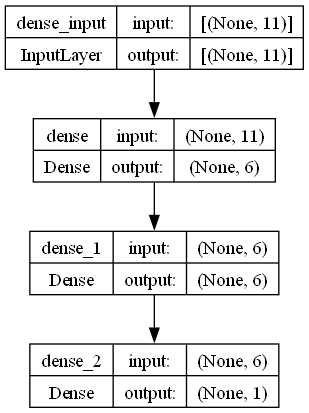

In [7]:
plot_model(classifier, to_file='churning_model.png', show_shapes=True, show_layer_names=True)

## Análisis de rendimiento

In [7]:
y_pred  = classifier.predict(X_test).flatten()
y_pred = (y_pred>0.5)
y_pred

63/63 [==============================] - 0s 3ms/step


array([False, False, False, ..., False, False, False])

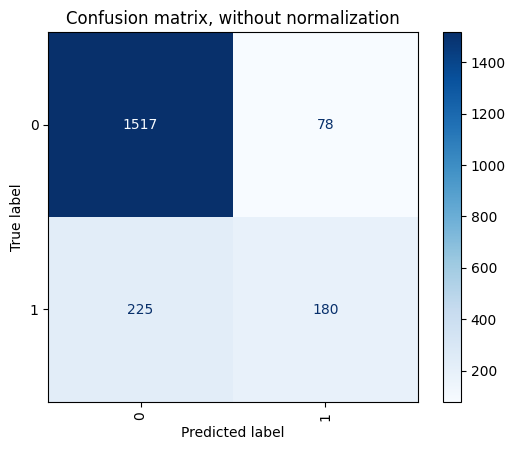

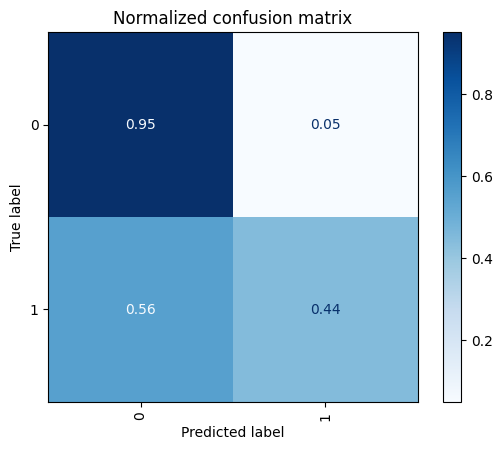

In [10]:
cm = confusion_matrix(y_test, y_pred)
classes = ['0', '1']
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    if normalize:
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=classes)
    
    disp.plot(cmap=plt.cm.Blues, values_format='.2f' if normalize else 'd', xticks_rotation='vertical')
    plt.title(title)
    plt.show()

In [11]:
y_pred  = classifier.predict(X_test).flatten()

12/63 [====>.........................] - ETA: 0s

63/63 [==============================] - 0s 5ms/step


In [13]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8418375324122451

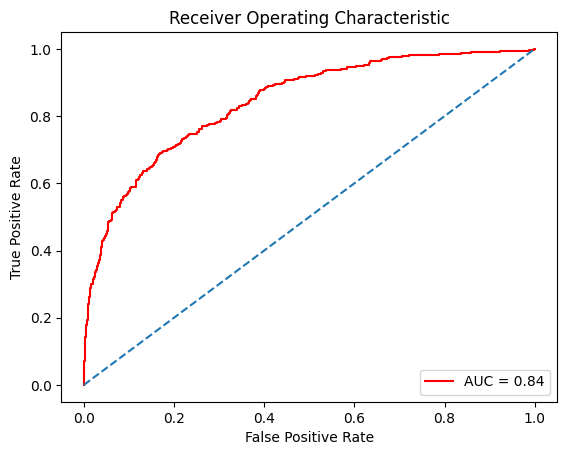

In [14]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Decente puntaje AUC pero la matriz de confusión muestra que hay varios falsos negativos

Desbalance de target, esta es la causa de la gran cantidad de falsos negativos

In [63]:
clase_count = pd.Series(y).value_counts()
print("Recuento de muestras por clase:")
clase_count

Recuento de muestras por clase:


0    7963
1    2037
Name: count, dtype: int64

## Smote

In [44]:
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X, y)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.2, random_state = 0)

In [48]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [50]:
classifier = Sequential()
classifier.add(Dense(units = 6, kernel_initializer = "uniform",  activation = "relu", input_dim = 11))
classifier.add(Dense(units = 6, kernel_initializer = "uniform",  activation = "relu"))
classifier.add(Dense(units = 1, kernel_initializer = "uniform",  activation = "sigmoid"))

classifier.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
classifier.fit(X_train, y_train,  batch_size = 10, epochs = 100)

Epoch 1/100
1274/1274 [==============================] - 7s 4ms/step - loss: 0.5732 - accuracy: 0.7130
Epoch 2/100
1274/1274 [==============================] - 4s 3ms/step - loss: 0.5088 - accuracy: 0.7558
Epoch 3/100
1274/1274 [==============================] - 5s 4ms/step - loss: 0.4724 - accuracy: 0.7766
Epoch 4/100
1274/1274 [==============================] - 7s 6ms/step - loss: 0.4541 - accuracy: 0.7885
Epoch 5/100
1274/1274 [==============================] - 9s 7ms/step - loss: 0.4379 - accuracy: 0.8012
Epoch 6/100
1274/1274 [==============================] - 5s 4ms/step - loss: 0.4258 - accuracy: 0.8047
Epoch 7/100
1274/1274 [==============================] - 5s 4ms/step - loss: 0.4133 - accuracy: 0.8109
Epoch 8/100
1274/1274 [==============================] - 5s 4ms/step - loss: 0.4028 - accuracy: 0.8155
Epoch 9/100
1274/1274 [==============================] - 6s 5ms/step - loss: 0.3959 - accuracy: 0.8179
Epoch 10/100
1274/1274 [==============================] - 7s 5ms/step - l

In [51]:
y_pred  = classifier.predict(X_test).flatten()
y_pred = (y_pred>0.5)
y_pred

100/100 [==============================] - 1s 6ms/step


array([ True, False,  True, ..., False,  True, False])

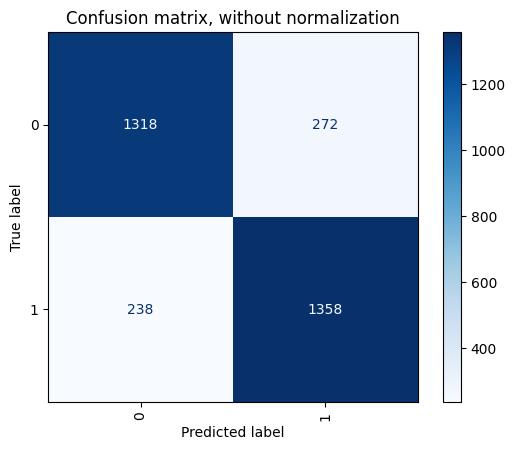

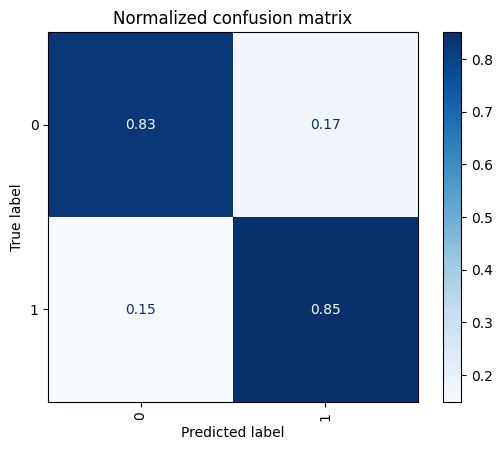

In [55]:
cm = confusion_matrix(y_test, y_pred)
classes = ['0', '1']
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    if normalize:
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=classes)
    
    disp.plot(cmap=plt.cm.Blues, values_format='.2f' if normalize else 'd', xticks_rotation='vertical')
    plt.title(title)
    plt.show()

In [56]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8399040052962595

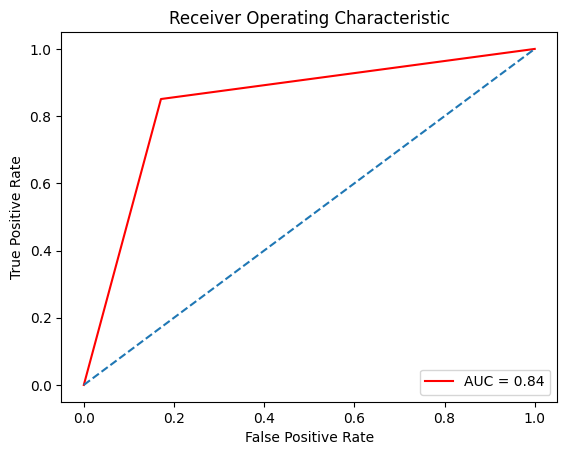

In [57]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Tuning

In [58]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units = hp.Int('units_1', min_value=4, max_value=24, step=2),
                    kernel_initializer = hp.Choice('kernel_initializer', values=['uniform', 'glorot_uniform', 'he_normal']),
                    activation = "relu",
                    input_dim = 11))
    model.add(Dense(units = hp.Int('units_2', min_value=4, max_value=24, step=2),
                    kernel_initializer = hp.Choice('kernel_initializer', values=['uniform', 'glorot_uniform', 'he_normal']),
                    activation = "relu"))
    model.add(Dense(units = 1, 
                    kernel_initializer = "uniform", 
                    activation = "sigmoid"))
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd']),
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=5,
    directory='my_dir',
    project_name='churn_model'
)

tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test))
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Trial 20 Complete [00h 15m 11s]
val_accuracy: 0.8666038870811462

Best val_accuracy So Far: 0.8873822927474976
Total elapsed time: 05h 56m 16s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                288       
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 913
Trainable params: 913
Non-trainable params: 0
_________________________________________________________________


In [59]:
y_pred_tune  = best_model.predict(X_test).flatten()
y_pred_tune = (y_pred_tune>0.5)
y_pred_tune

100/100 [==============================] - 0s 3ms/step


array([ True,  True,  True, ..., False,  True, False])

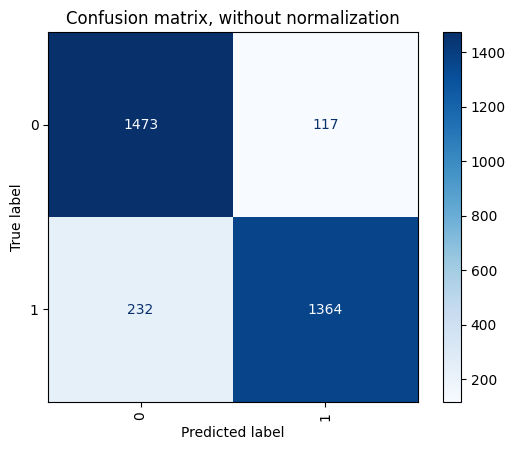

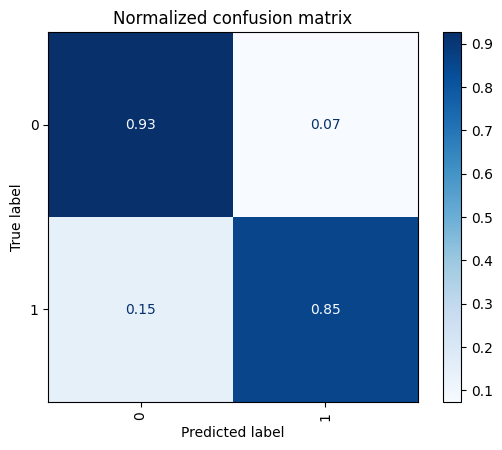

In [60]:
cm_tuned = confusion_matrix(y_test, y_pred_tune)
classes = ['0', '1']
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_tuned, display_labels=classes)
    if normalize:
        cm_normalized = cm_tuned.astype('float') / cm_tuned.sum(axis=1)[:, np.newaxis]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=classes)
    
    disp.plot(cmap=plt.cm.Blues, values_format='.2f' if normalize else 'd', xticks_rotation='vertical')
    plt.title(title)
    plt.show()

In [61]:
false_positive_rate_tuned, true_positive_rate_tuned, thresholds_tuned = roc_curve(y_test, y_pred_tune)
roc_auc_tuned = auc(false_positive_rate_tuned, true_positive_rate_tuned)
roc_auc_tuned

0.8905258429091597

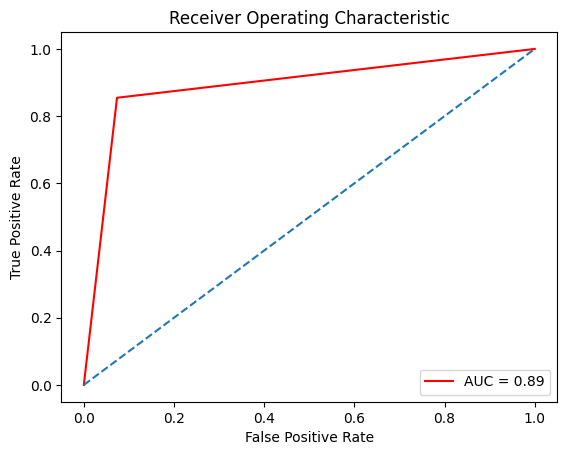

In [62]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate_tuned, true_positive_rate_tuned, color='red',label = 'AUC = %0.2f' % roc_auc_tuned)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [10]:
# Guardar el modelo
best_model.save('./models/best_model.h5')

In [ ]:
# Cargar el modelo
loaded_model = load_model('./models/best_model.h5')